In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
from flask import Flask, request, render_template
import re
import matplotlib.pyplot as plt
import json
import numpy as np
import nltk
import seaborn as sns

In [3]:
credit = pd.read_csv(r'/Users/iqrabismi/Desktop/projects/MoviestRecommendationSystem/MoviesRecommendationSystem/tmdb_5000_credits.csv')

In [4]:
credit.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


## Collaborative Filtering 

In [5]:
movies= pd.read_csv(r'/Users/iqrabismi/Desktop/ml-latest/movies.csv')

In [6]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [8]:
rating= pd.read_csv(r'/Users/iqrabismi/Desktop/projects/MoviestRecommendationSystem/MoviesRecommendationSystem/ratings_small.csv')

In [9]:
rating.head(3)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


In [10]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## EDA

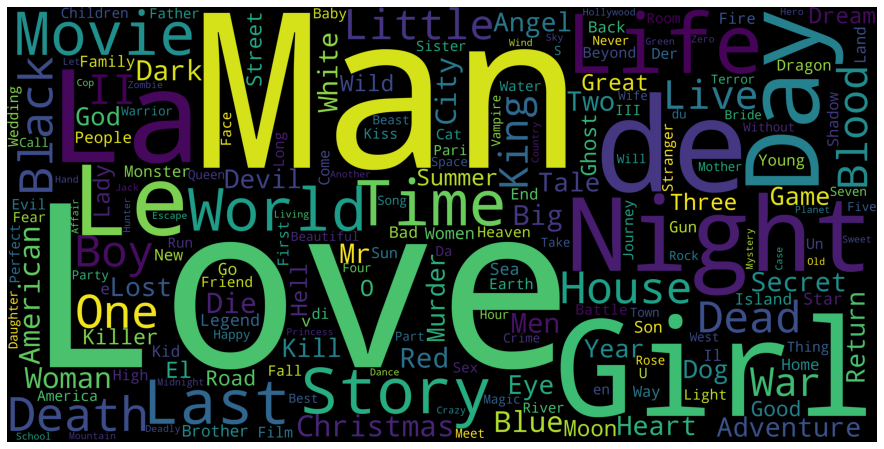

In [11]:
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [12]:
# Get summary statistics of rating
rating['rating'].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

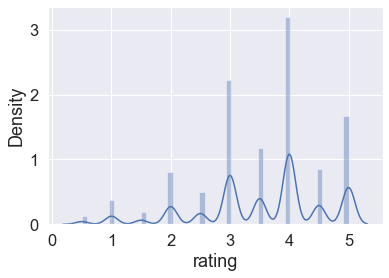

In [13]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(rating['rating'].fillna(rating['rating'].median()))

It seems that the ratings provided by users are generally high, with a mean rating of 3.58 out of 5. A large portion of the movies have received ratings of 4 and 5. This could indicate that the 5-level rating system may not have been the best choice, as users may have different rating styles, and some may be more generous with their ratings than others. Additionally, since each user has rated at least 20 movies, it is unlikely that this distribution is simply a result of chance variation in the quality of the movies. To further investigate, let's take a closer look at a subset of 20 movies with the highest ratings.

In [14]:
# Join all 3 files into one dataframe
df = movies.merge(rating, on= 'movieId')
# Display 20 movies with highest ratings
df[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

,title,genres,rating
99957,The Beatles: Eight Days a Week - The Touring Y...,Documentary,5.0
49811,Shakespeare in Love (1998),Comedy|Drama|Romance,5.0
49817,Shakespeare in Love (1998),Comedy|Drama|Romance,5.0
19597,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical,5.0
49819,Shakespeare in Love (1998),Comedy|Drama|Romance,5.0
19594,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical,5.0
49822,Shakespeare in Love (1998),Comedy|Drama|Romance,5.0
49823,Shakespeare in Love (1998),Comedy|Drama|Romance,5.0
19589,James and the Giant Peach (1996),Adventure|Animation|Children|Fantasy|Musical,5.0
49830,Miracle on 34th Street (1947),Comedy|Drama,5.0


##### Taking the count for Genre

In [15]:
df.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179


In [16]:
def f(x):
    return x.split('|')

In [17]:
df['genres'] = df['genres'].apply(f)

In [18]:
df.genres.values[0]
    

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']

In [19]:
genre=[]

for i in df.genres.values:
    for j in i:
        if type(j) != list:
            genre.append(j)

In [20]:
from collections import Counter
C= Counter(genre)

print(C.most_common(5)) #Top five most watched genre

[('Drama', 44725), ('Comedy', 38022), ('Action', 27029), ('Thriller', 25240), ('Adventure', 22014)]


### Model Based Collaborative Filtering

Collaborative filtering approaches that rely on computing distance relationships between items or users, also known as memory-based methods, have a few limitations. One major issue is that they may not perform well with large datasets, particularly when it comes to providing real-time recommendations based on user behavior similarities. Additionally, using distance-based "neighborhood" approaches on raw data can lead to overfitting, as the ratings matrices may be based on noisy representations of user tastes and preferences. To address these issues, it is important to use dimensionality reduction techniques, such as Singular Vector Decomposition (SVD), to extract the underlying tastes and preferences from the raw data. By reducing the dimensions of the data, we can discover hidden correlations and features, remove noisy and redundant information, and make the data easier to interpret, visualize, and process. SVD is a powerful technique that is widely used in modern model-based collaborative filtering recommender systems.

Model-based Collaborative Filtering is a technique that utilizes matrix factorization to make recommendations. It is considered a more advanced approach than Memory-based Collaborative Filtering and is better suited for handling large and sparse datasets. The goal of MF is to learn the underlying preferences of users and the attributes of items from known ratings and use this information to predict unknown ratings. This is achieved by decomposing the user-item matrix into a low-rank structure, where the rows contain latent vectors. By multiplying these low-rank matrices together, we can approximate the original matrix and fill in the missing entries. This approach allows for better scalability and handling of sparsity in comparison to memory-based methods.


In [28]:
n_users = rating.userId.nunique()
n_movies = rating.movieId.nunique()
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 671 | Number of movies = 9066


Format of my rating matrix to be one row per user and one column per movie. To do so, I will pivot ratings to get that and call the new variable Ratings (with a capital *R).

In [27]:
ratings = rating.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
ratings.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Normalising

In [30]:
R = ratings.values
user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [25]:
# checking the sparsity of the dataset

sparsity = round(1.0 - len(rating) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens1M dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens1M dataset is 98.4%


### Support Vector Decomposition (SVD)


SVD is an algorithm that decomposes a matrix into a lower rank approximation of the original matrix. It does this by breaking down the matrix into three parts: two unitary matrices and a diagonal matrix. The input data matrix is represented by A, the left singular vectors is represented by U, the diagonal matrix of singular values is represented by Sigma, and the right singular vectors is represented by V. U and V are column orthonormal and they represent different things. U represents how much users "like" each feature, and V represents how relevant each feature is to each movie. To get the lower rank approximation, we keep only the top features, which can be thought of as the underlying tastes and preferences vectors.

In [33]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

The returned values are the three matrices of the SVD decomposition:

1. U: the left singular vectors of the input matrix Ratings_demeaned, It represents how much users "like" each feature.
2. sigma: the diagonal matrix of singular values, It is a 1-D array containing the singular values in descending order. These values are essentially weights/strengths of each concept.
3. Vt: the transpose of the right singular vectors of the input matrix Ratings_demeaned, It represents how relevant each feature is to each movie.

##### Sigma is being converted from a 1-D array to a 2-D diagonal matrix using the np.diag() function from the NumPy library. This is done because the original sigma variable is an array containing the singular values in descending order, and these values will be used as the diagonal entries of a matrix. By converting it to a diagonal matrix, it is easier to perform matrix multiplication with the other two matrices (U and Vt) that are part of the SVD decomposition. It also allows to maintain the property of the decomposition of matrix A = U * sigma * Vt.In the context of collaborative filtering, the goal is to reconstruct the original matrix as close as possible, and in this case, by converting sigma into a diagonal matrix, it makes it possible to perform matrix multiplications with U and Vt matrices that can be used to reconstruct the original matrix.

In [34]:
sigma = np.diag(sigma)

##### Making Predictions from the Decomposed Matrices

Now that I have all the necessary information and components, I can make movie ratings predictions for every user by following the mathematical process and multiplying matrices U, sigma, and Vt to get the lower rank approximation of the original matrix. However, before doing so, I need to add the mean ratings for each user back into the predictions in order to obtain the actual star ratings predictions.

In [35]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

I can create a recommendation function using the predictions matrix for each user and return a list of movies that the user has already rated for comparison.

In [37]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = ratings.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.054239,0.045130,-0.004835,-0.019817,-0.011284,0.041373,-0.007822,-0.017188,0.012246,0.037670,...,-0.005258,-0.005453,0.012369,-0.004991,-0.004639,-0.019055,0.021402,-0.006365,-0.006098,-0.004819
1,0.419835,1.406440,-0.188807,0.156658,0.268032,0.414698,0.052172,0.044728,-0.020198,2.220256,...,-0.005909,-0.003974,-0.012555,-0.003555,-0.002711,-0.071621,-0.016212,0.001047,-0.001468,-0.006577
2,1.345619,0.266505,-0.011962,0.012278,0.079508,0.090960,-0.122094,0.031327,-0.018023,0.141176,...,-0.002647,-0.002364,-0.010153,0.000277,-0.000116,-0.018063,-0.015761,0.010611,0.006792,-0.006357
3,1.133455,1.046982,0.141275,0.081841,-0.339675,-1.484659,-0.263096,-0.169750,-0.021862,1.611664,...,0.020805,0.000410,0.056040,-0.002817,-0.000767,0.159159,0.087519,-0.030854,-0.021279,0.048529
4,1.389578,1.466495,0.605557,-0.029647,0.729380,-0.118539,-0.026017,0.065577,-0.156655,0.307926,...,-0.007422,-0.011810,0.006644,-0.005159,-0.001249,-0.034658,0.016456,0.001710,-0.004166,-0.001864


I will now write a function that returns the movies with the highest predicted rating that the specified user has not yet rated. To provide more context to the recommendations, I will also merge in movie content information such as genre and title even though I didn't use any explicit movie content features in the prediction process.

In [50]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [51]:
already_rated, predictions = recommend_movies(preds, 1, movies, rating, 20)

User 1 has already rated 20 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [52]:
# Top 20 movies that User 1310 has rated 
already_rated.head(20)

,userId,movieId,rating,timestamp,title,genres
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
13,1,2105,4.0,1260759139,Tron (1982),Action|Adventure|Sci-Fi
12,1,1953,4.0,1260759191,"French Connection, The (1971)",Action|Crime|Thriller
8,1,1339,3.5,1260759125,Dracula (Bram Stoker's Dracula) (1992),Fantasy|Horror|Romance|Thriller
19,1,3671,3.0,1260759117,Blazing Saddles (1974),Comedy|Western
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
14,1,2150,3.0,1260759194,"Gods Must Be Crazy, The (1980)",Adventure|Comedy
17,1,2455,2.5,1260759113,"Fly, The (1986)",Drama|Horror|Sci-Fi|Thriller
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama


In [53]:
# Top 20 movies that User 1310 hopefully will enjoy
predictions

,movieId,title,genres
1332,1374,Star Trek II: The Wrath of Khan (1982),Action|Adventure|Sci-Fi|Thriller
1858,1954,Rocky (1976),Drama
2883,2987,Who Framed Roger Rabbit? (1988),Adventure|Animation|Children|Comedy|Crime|Fant...
3070,3175,Galaxy Quest (1999),Adventure|Comedy|Sci-Fi
3372,3479,Ladyhawke (1985),Adventure|Fantasy|Romance
2844,2947,Goldfinger (1964),Action|Adventure|Thriller
2305,2406,Romancing the Stone (1984),Action|Adventure|Comedy|Romance
1248,1282,Fantasia (1940),Animation|Children|Fantasy|Musical
1861,1957,Chariots of Fire (1981),Drama
1171,1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western


The recommendations seem to be quite accurate. It's interesting to see that even though genre was not used as a feature, the truncated matrix factorization was able to identify the user's tastes and preferences. The recommendations include a mix of comedy, drama and romance movies, which are genres that the user has previously rated highly.